In [1]:
import os
print(os.listdir("input"))

['all-dogs', 'Annotation']


In [2]:
from __future__ import print_function
import time
import shutil
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm.notebook import tqdm

There are 20579 pictures of dogs.


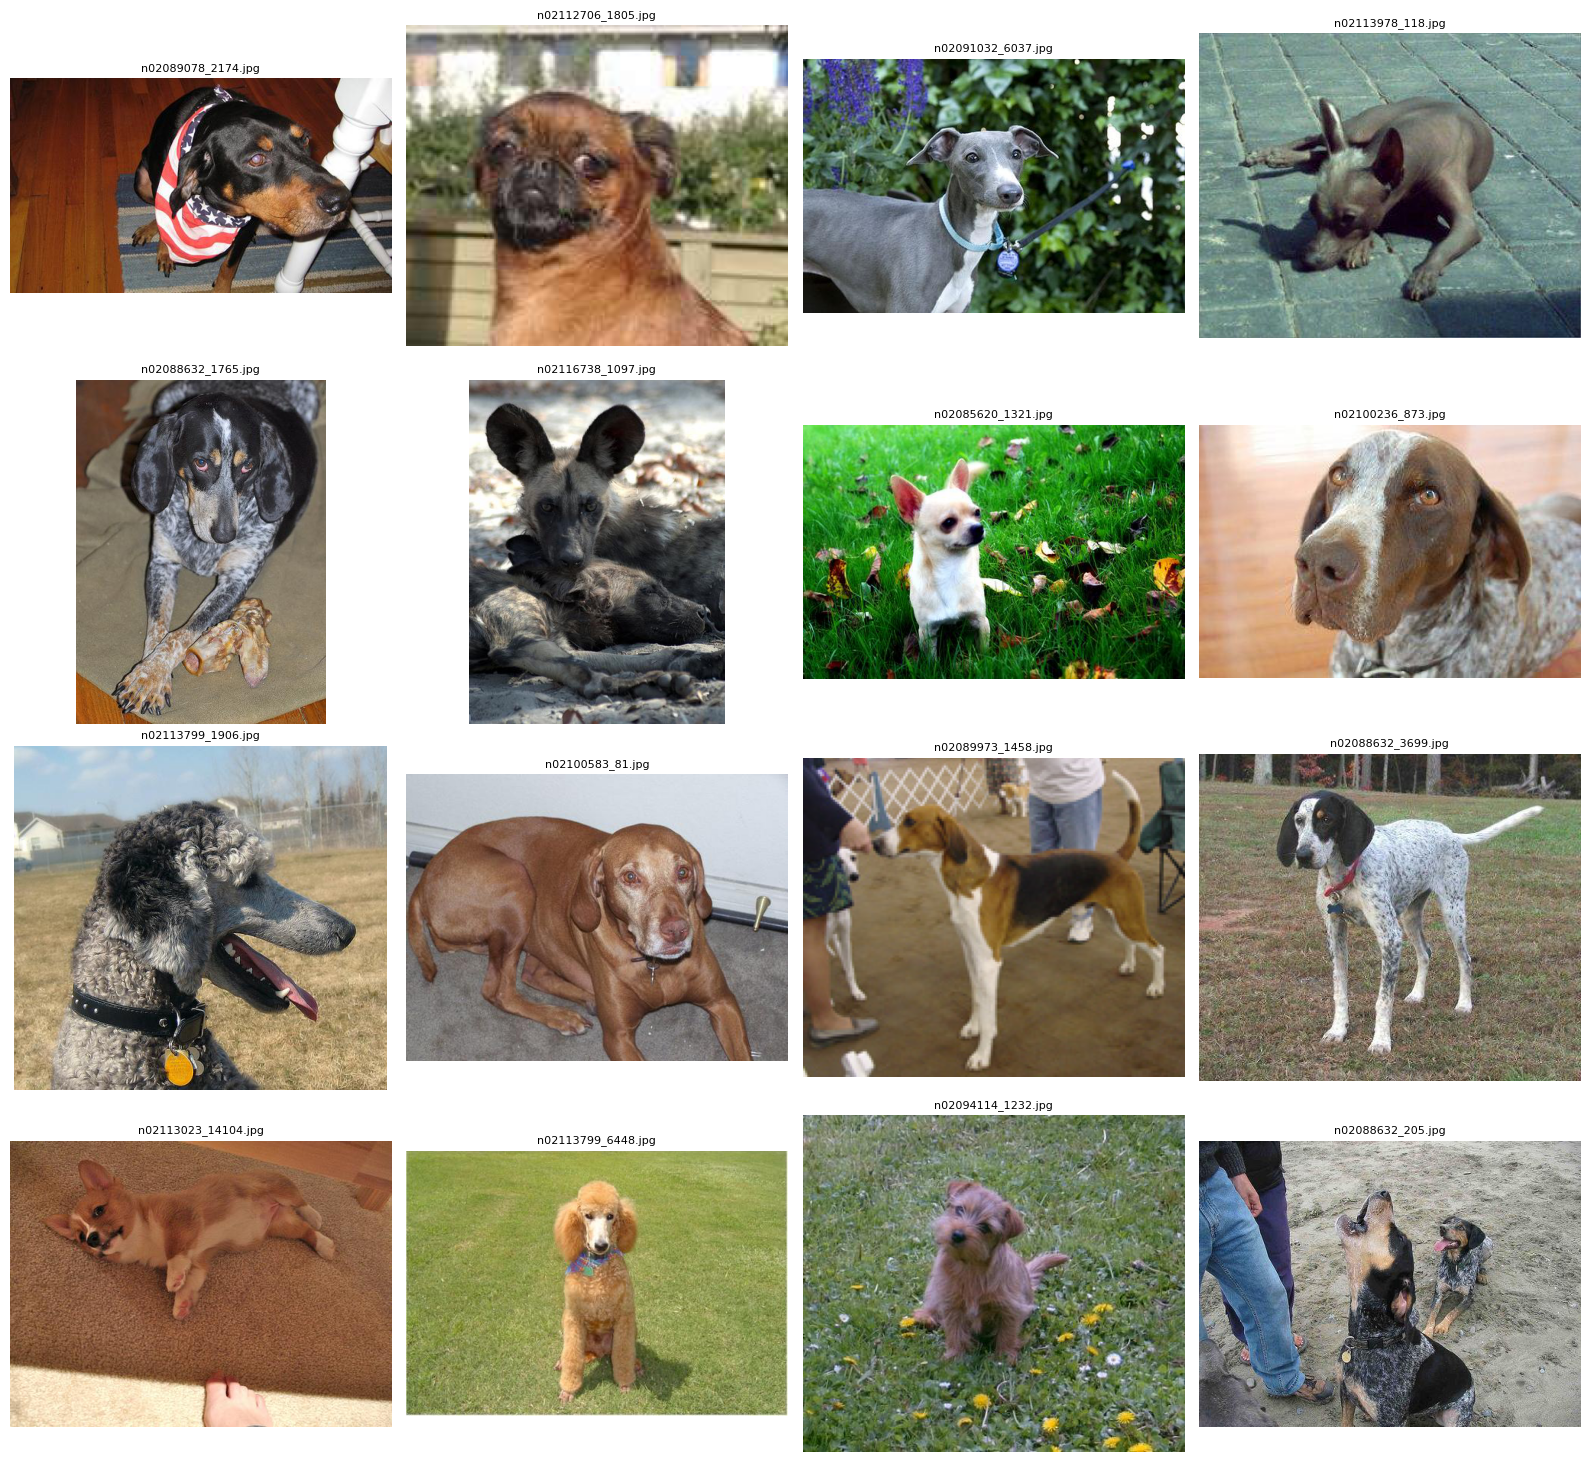

In [3]:
# Define the path to the images
PATH = 'input/all-dogs/all-dogs/'
images = os.listdir(PATH)
print(f'There are {len(images)} pictures of dogs.')

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(16,16))

for indx, axis in enumerate(axes.flatten()):
    rnd_indx = np.random.randint(0, len(images))
    img = plt.imread(os.path.join(PATH, images[rnd_indx]))
    axis.imshow(img)
    axis.set_title(images[rnd_indx], fontsize=8)
    axis.set_axis_off()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [4]:
batch_size = 32
image_size = 64

# 64x64 images
transform = transforms.Compose([transforms.Resize(image_size),
                                transforms.CenterCrop(image_size),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.ImageFolder('input/all-dogs/', transform=transform)

dataloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)

imgs, label = next(iter(dataloader))
imgs = imgs.numpy().transpose(0, 2, 3, 1)


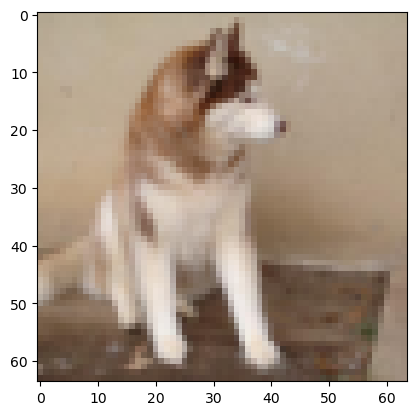

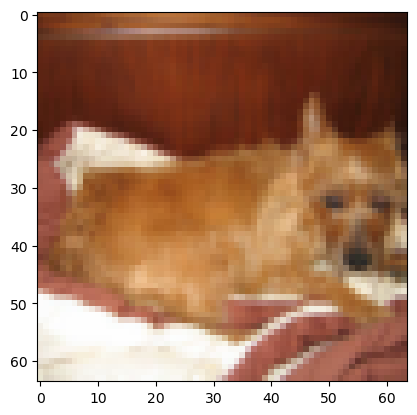

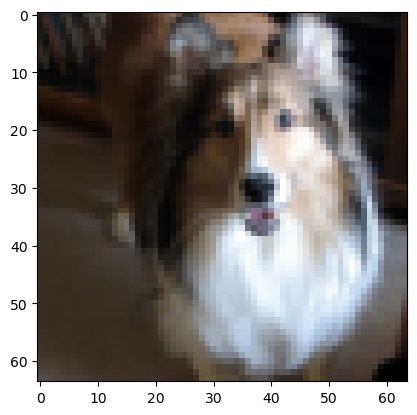

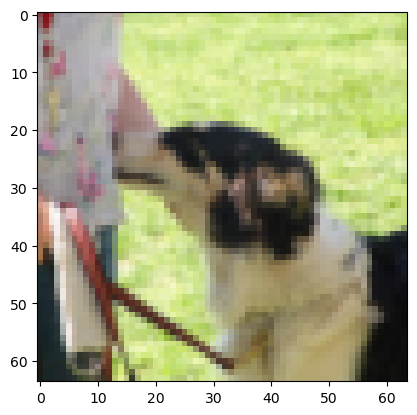

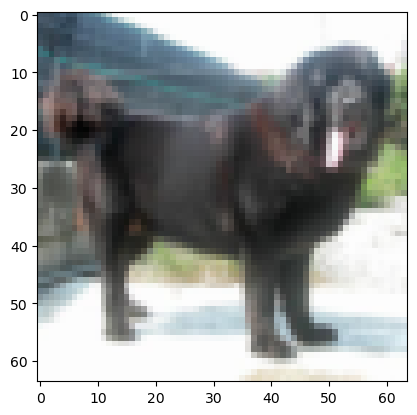

In [5]:
for i in range(5):
    img = (imgs[i] * 0.5) + 0.5  # Unnormalize the image
    plt.imshow(img)
    plt.show()

In [6]:
# Generator
class Generator(nn.Module):
    def __init__(self, z_dim=100, im_chan=3, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 8, kernel_size=4, stride=1, padding=0),
            self.make_gen_block(hidden_dim * 8, hidden_dim * 4, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = noise.view(len(noise), self.z_dim, 1, 1)
        return self.gen(x)

In [7]:
# Discriminator (Critic)
class Discriminator(nn.Module):
    def __init__(self, im_chan=3, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, hidden_dim * 4),
            self.make_disc_block(hidden_dim * 4, hidden_dim * 8),
            nn.Conv2d(hidden_dim * 8, 1, kernel_size=4, stride=1)
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [8]:
# Helper functions for WGAN-GP
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

def get_gradient(disc, real, fake, epsilon):
    epsilon = epsilon.expand_as(real)
    mixed_images = epsilon * real + (1 - epsilon) * fake
    mixed_scores = disc(mixed_images)
    gradient = torch.autograd.grad(
        inputs=mixed_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores), 
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

def gradient_penalty(gradient):
    gradient = gradient.view(len(gradient), -1)
    gradient_norm = gradient.norm(2, dim=1)
    penalty = torch.mean((gradient_norm - 1)**2)
    return penalty

def get_gen_loss(disc_fake_pred):
    gen_loss = -1. * torch.mean(disc_fake_pred)
    return gen_loss

def get_disc_loss(disc_fake_pred, disc_real_pred, gp, c_lambda):
    disc_loss = torch.mean(disc_fake_pred) - torch.mean(disc_real_pred) + c_lambda * gp
    return disc_loss

In [9]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lr = 0.0002
beta1 = 0.5
beta2 = 0.999
c_lambda = 10
disc_repeats = 2 # Fewer updates to discriminator
n_epochs = 100
z_dim = 100

# Reduce learning rate for discriminator because in previous tests, the discriminator tends to learn much better than the generator
gen = Generator(z_dim=z_dim).to(device)
gen_opt = optim.Adam(gen.parameters(), lr=lr, betas=(beta1, beta2))
disc = Discriminator().to(device)
disc_opt = optim.Adam(disc.parameters(), lr=lr * 0.25, betas=(beta1, beta2)) # Reduced learning rate for discriminator

# Initialize weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

gen.apply(weights_init)
disc.apply(weights_init)

# Training loop
cur_step = 0
generator_losses = []
discriminator_losses = []
for epoch in range(n_epochs):
    for i, (real, _) in enumerate(tqdm(dataloader, desc=f"Epoch [{epoch+1}/{n_epochs}]")):
        cur_batch_size = len(real)
        real = real.to(device)

        mean_iteration_disc_loss = 0
        for _ in range(disc_repeats):
            disc_opt.zero_grad()
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            
            disc_fake_pred = disc(fake.detach())
            disc_real_pred = disc(real)

            epsilon = torch.rand(cur_batch_size, 1, 1, 1, device=device, requires_grad=True)
            gradient = get_gradient(disc, real, fake.detach(), epsilon)
            gp = gradient_penalty(gradient)
            disc_loss = get_disc_loss(disc_fake_pred, disc_real_pred, gp, c_lambda)

            mean_iteration_disc_loss += disc_loss.item() / disc_repeats
            disc_loss.backward(retain_graph=True)
            disc_opt.step()
        discriminator_losses.append(mean_iteration_disc_loss)

        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = get_gen_loss(disc_fake_pred)
        gen_loss.backward()
        gen_opt.step()
        generator_losses.append(gen_loss.item())

        cur_step += 1

    # Print the losses every 5 epochs
    if (epoch + 1) % 5 == 0:
        gen_mean = sum(generator_losses[-len(dataloader):]) / len(dataloader)
        disc_mean = sum(discriminator_losses[-len(dataloader):]) / len(dataloader)
        print(f"[{epoch+1}/{n_epochs}] Loss_D: {disc_mean} Loss_G: {gen_mean}")

# Generate images
if not os.path.exists('../output_images'):
    os.mkdir('../output_images')

im_batch_size = 50
n_images = 10000
for i_batch in range(0, n_images, im_batch_size):
    gen_z = torch.randn(im_batch_size, z_dim, 1, 1, device=device)
    gen_images = gen(gen_z)
    images = gen_images.to("cpu").clone().detach()
    images = images.numpy().transpose(0, 2, 3, 1)
    for i_image in range(gen_images.size(0)):
        save_image(gen_images[i_image, :, :, :], os.path.join('../output_images', f'image_{i_batch + i_image:05d}.png'))

shutil.make_archive('images', 'zip', '../output_images')

Epoch [1/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [2/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [3/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [4/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [5/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[5/100] Loss_D: -2.3766432736034258 Loss_G: 18.245218472451157


Epoch [6/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [7/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [8/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [9/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [10/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[10/100] Loss_D: -2.1284663217425672 Loss_G: 27.10367157148278


Epoch [11/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [12/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [13/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [14/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [15/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[15/100] Loss_D: -1.997260081804479 Loss_G: 30.5113365990775


Epoch [16/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [17/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [18/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [19/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [20/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[20/100] Loss_D: -1.888906442808994 Loss_G: 32.94070078275219


Epoch [21/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [22/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [23/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [24/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [25/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[25/100] Loss_D: -1.9416444061196738 Loss_G: 34.21397452917158


Epoch [26/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [27/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [28/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [29/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [30/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[30/100] Loss_D: -2.0061725647252353 Loss_G: 36.43668360739761


Epoch [31/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [32/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [33/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [34/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [35/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[35/100] Loss_D: -2.0894578159179376 Loss_G: 38.90053210051163


Epoch [36/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [37/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [38/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [39/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [40/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[40/100] Loss_D: -2.1788227197870333 Loss_G: 41.422437685617005


Epoch [41/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [42/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [43/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [44/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [45/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[45/100] Loss_D: -2.280532324802339 Loss_G: 44.380239800636815


Epoch [46/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [47/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [48/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [49/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [50/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[50/100] Loss_D: -2.436261129374645 Loss_G: 47.11550166444008


Epoch [51/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [52/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [53/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [54/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [55/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[55/100] Loss_D: -2.569831242935258 Loss_G: 49.46807821048713


Epoch [56/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [57/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [58/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [59/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [60/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[60/100] Loss_D: -2.7210878651149524 Loss_G: 52.202689348540694


Epoch [61/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [62/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [63/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [64/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [65/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[65/100] Loss_D: -2.865734786211704 Loss_G: 54.52154660076828


Epoch [66/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [67/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [68/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [69/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [70/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[70/100] Loss_D: -3.042467935739652 Loss_G: 56.879300336660066


Epoch [71/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [72/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [73/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [74/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [75/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[75/100] Loss_D: -3.202582563950408 Loss_G: 59.21299281031449


Epoch [76/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [77/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [78/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [79/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [80/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[80/100] Loss_D: -3.404084594631047 Loss_G: 61.623332805515076


Epoch [81/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [82/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [83/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [84/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [85/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[85/100] Loss_D: -3.5673389084035567 Loss_G: 63.7307454044034


Epoch [86/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [87/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [88/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [89/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [90/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[90/100] Loss_D: -3.7127871105204457 Loss_G: 65.7462663413575


Epoch [91/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [92/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [93/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [94/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [95/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[95/100] Loss_D: -3.8695707778382746 Loss_G: 68.41405258415648


Epoch [96/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [97/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [98/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [99/100]:   0%|          | 0/644 [00:00<?, ?it/s]

Epoch [100/100]:   0%|          | 0/644 [00:00<?, ?it/s]

[100/100] Loss_D: -4.060742411045184 Loss_G: 70.80165235152155


'C:\\Users\\HP\\Desktop\\images.zip'

There are 9 selected pictures.


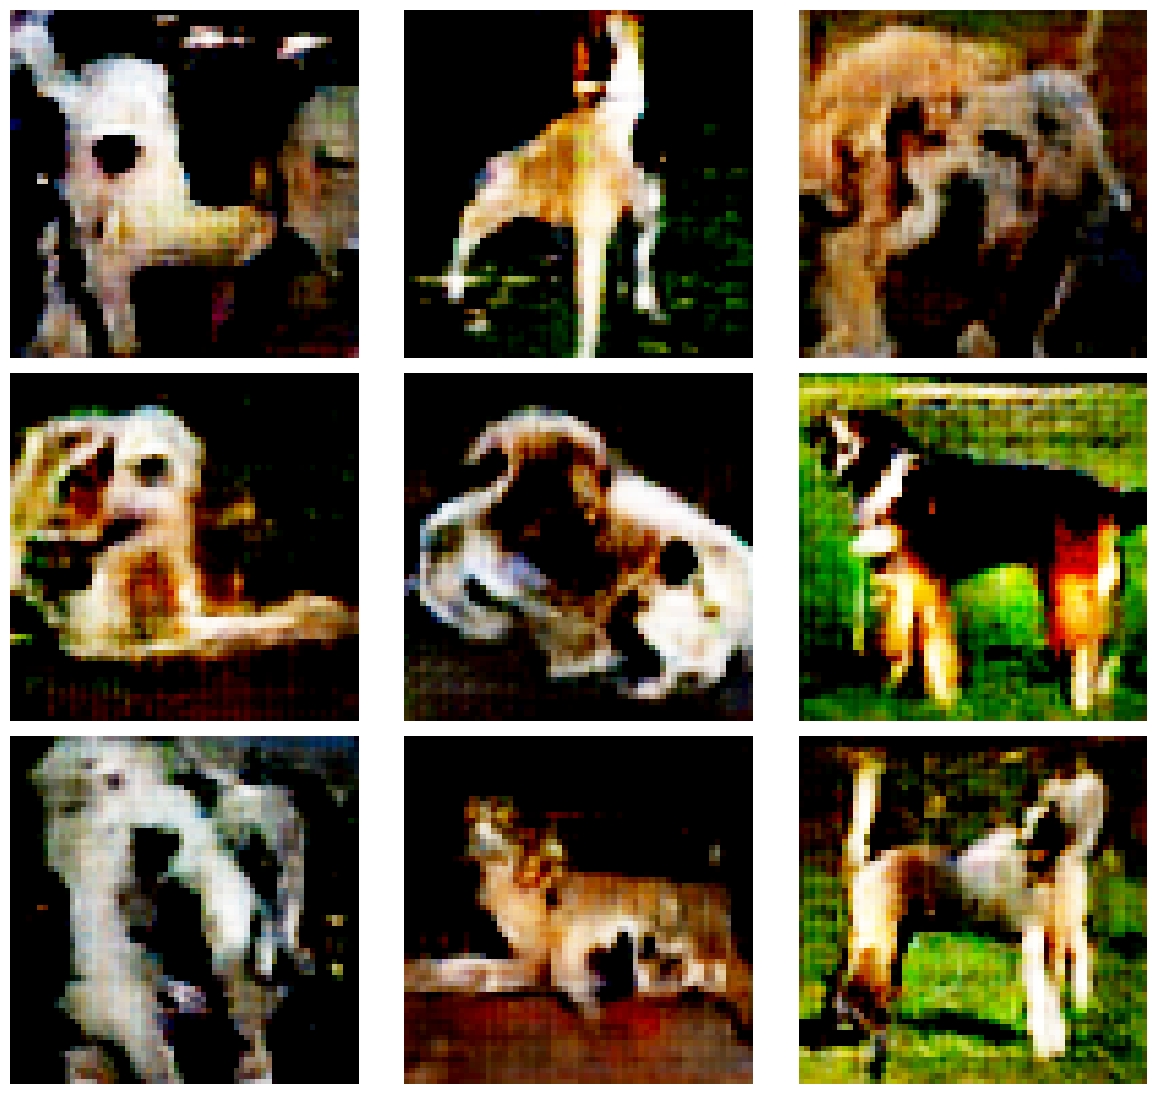

In [11]:
# Define the path to the selected images
SPATH = 'select-images/'
images = os.listdir(SPATH)
print(f'There are {len(images)} selected pictures.')

# Create a 3x3 grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for indx, axis in enumerate(axes.flatten()):
    if indx < len(images):
        img = plt.imread(os.path.join(SPATH, images[indx]))
        axis.imshow(img)
        axis.set_axis_off()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()